# Exploratory Data Analysis

This notebook explores triage patterns using only `cleaned.csv`, with KTAS expert classification as the main focus.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)

### Findings Notes
This cell configures libraries and display settings. There are no data findings yet.

In [2]:
DATA_PATH = "cleaned.csv"

df = pd.read_csv(DATA_PATH)
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

print(f"Loaded: {DATA_PATH}")
print(f"Shape: {df.shape}")
df.head()

Loaded: cleaned.csv
Shape: (1267, 14)


,Age,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,KTAS_expert,Sex_Male,Injury_Yes,Pain_Yes,Mental_ord
0,71,2.0,160.0,100.0,84.0,18.0,36.6,100.0,2,4,0,0,1,1
1,56,2.0,137.0,75.0,60.0,20.0,36.5,98.0,4,5,1,0,1,1
2,68,2.0,130.0,80.0,102.0,20.0,36.6,98.0,4,5,1,0,1,1
3,71,3.0,139.0,94.0,88.0,20.0,36.5,98.0,4,5,0,1,1,1
4,58,3.0,91.0,67.0,93.0,18.0,36.5,98.0,4,5,0,1,1,1


### Findings Notes
Data source is strictly `cleaned.csv`. Expected shape from this dataset is around 1.2k rows with 14 features after dropping `Unnamed: 0`.

In [3]:
quality = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "missing": df.isna().sum(),
    "unique_values": df.nunique()
}).sort_values(["missing", "unique_values"], ascending=[False, False])

print("Duplicate rows:", int(df.duplicated().sum()))
quality

Duplicate rows: 5


,dtype,missing,unique_values
SBP,float64,0,126
HR,float64,0,93
DBP,float64,0,82
Age,int64,0,81
BT,float64,0,41
Saturation,float64,0,21
NRS_pain,float64,0,10
RR,float64,0,10
KTAS_RN,int64,0,5
KTAS_expert,int64,0,5


### Findings Notes
- Missingness is clean across columns in this file (no null-heavy features).
- There are 5 duplicate rows, which is small but worth keeping in mind for modeling.

,count,percent
KTAS_expert,,
1,26,2.05
2,220,17.36
3,487,38.44
4,459,36.23
5,75,5.92


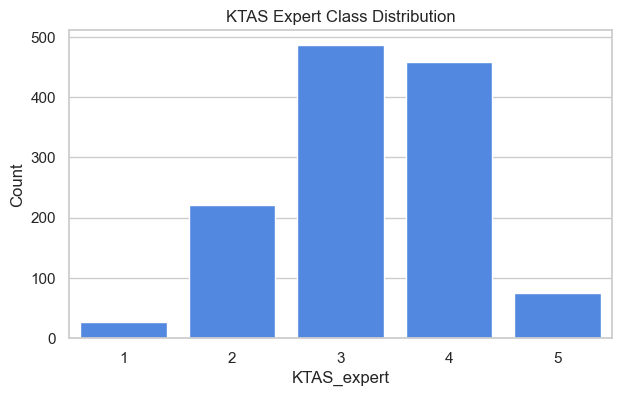

In [4]:
target_col = "KTAS_expert"

if target_col in df.columns:
    dist = df[target_col].value_counts().sort_index()
    pct = (dist / len(df) * 100).round(2)
    display(pd.DataFrame({"count": dist, "percent": pct}))

    fig, ax = plt.subplots(figsize=(7, 4))
    sns.barplot(x=dist.index.astype(str), y=dist.values, ax=ax, color="#3b82f6")
    ax.set_title("KTAS Expert Class Distribution")
    ax.set_xlabel("KTAS_expert")
    ax.set_ylabel("Count")
    plt.show()
else:
    print(f"Column {target_col} not found in dataset.")

### Findings Notes
- Class balance is centered in KTAS 3 and 4 (about 38% and 36%).
- KTAS 1 is rare (about 2%), so high-acuity cases are limited in count.
- This imbalance matters for downstream modeling and evaluation.

In [5]:
candidate_num_cols = [
    "Age", "NRS_pain", "SBP", "DBP", "HR", "RR",
    "BT", "Saturation", "KTAS_RN", "Mental_ord",
    "Sex_Male", "Injury_Yes", "Pain_Yes"
]
num_cols = [c for c in candidate_num_cols if c in df.columns]

if target_col in df.columns:
    by_target = df.groupby(target_col)[num_cols].mean().round(2)
    by_target
else:
    print("Target column missing; skipping grouped means.")

### Findings Notes
- Higher-acuity classes (KTAS 1-2) are older on average than KTAS 4-5.
- RR tends to be higher and oxygen saturation lower in higher-acuity groups.
- `Mental_ord` is notably higher in KTAS 1, consistent with altered mental status in critical presentations.

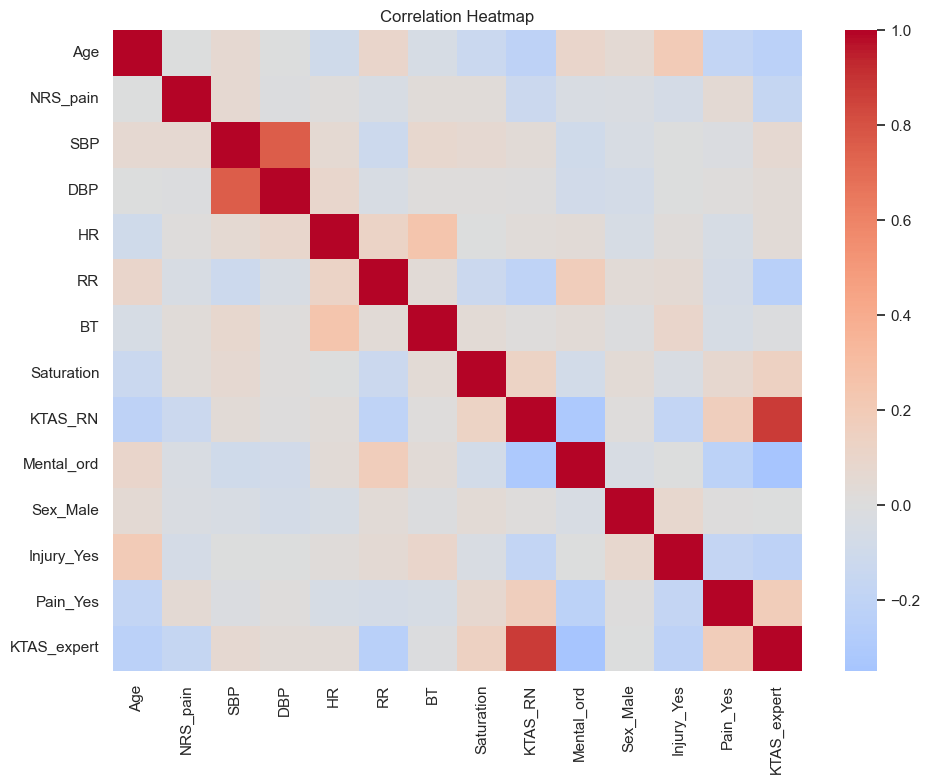

In [6]:
corr_cols = [c for c in num_cols + [target_col] if c in df.columns]
corr = df[corr_cols].corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, ax=ax)
ax.set_title("Correlation Heatmap")
plt.tight_layout()
plt.show()

if target_col in corr.columns:
    corr[target_col].sort_values(key=lambda s: s.abs(), ascending=False)

### Findings Notes
- Strongest linear alignment with `KTAS_expert` is `KTAS_RN` (high positive correlation).
- `Mental_ord`, `RR`, and `Age` show meaningful negative correlation with KTAS number (more abnormal tends toward higher acuity).
- Correlation here is directional association, not causality.

In [7]:
if {"KTAS_RN", "KTAS_expert"}.issubset(df.columns):
    agreement = (df["KTAS_RN"] == df["KTAS_expert"]).mean() * 100
    abs_diff = (df["KTAS_RN"] - df["KTAS_expert"]).abs()
    print(f"RN vs Expert exact agreement: {agreement:.2f}%")
    display(abs_diff.value_counts().sort_index().rename("count").to_frame())
else:
    print("KTAS_RN and/or KTAS_expert missing; skipping agreement check.")

RN vs Expert exact agreement: 85.32%


,count
0,1081
1,167
2,18
3,1


### Findings Notes
- RN and expert match exactly in about 85% of cases.
- Most mismatches are only one KTAS level apart, with very few large disagreements.
- This indicates strong but imperfect consistency between bedside and expert labeling.

## KTAS Expert-Focused EDA

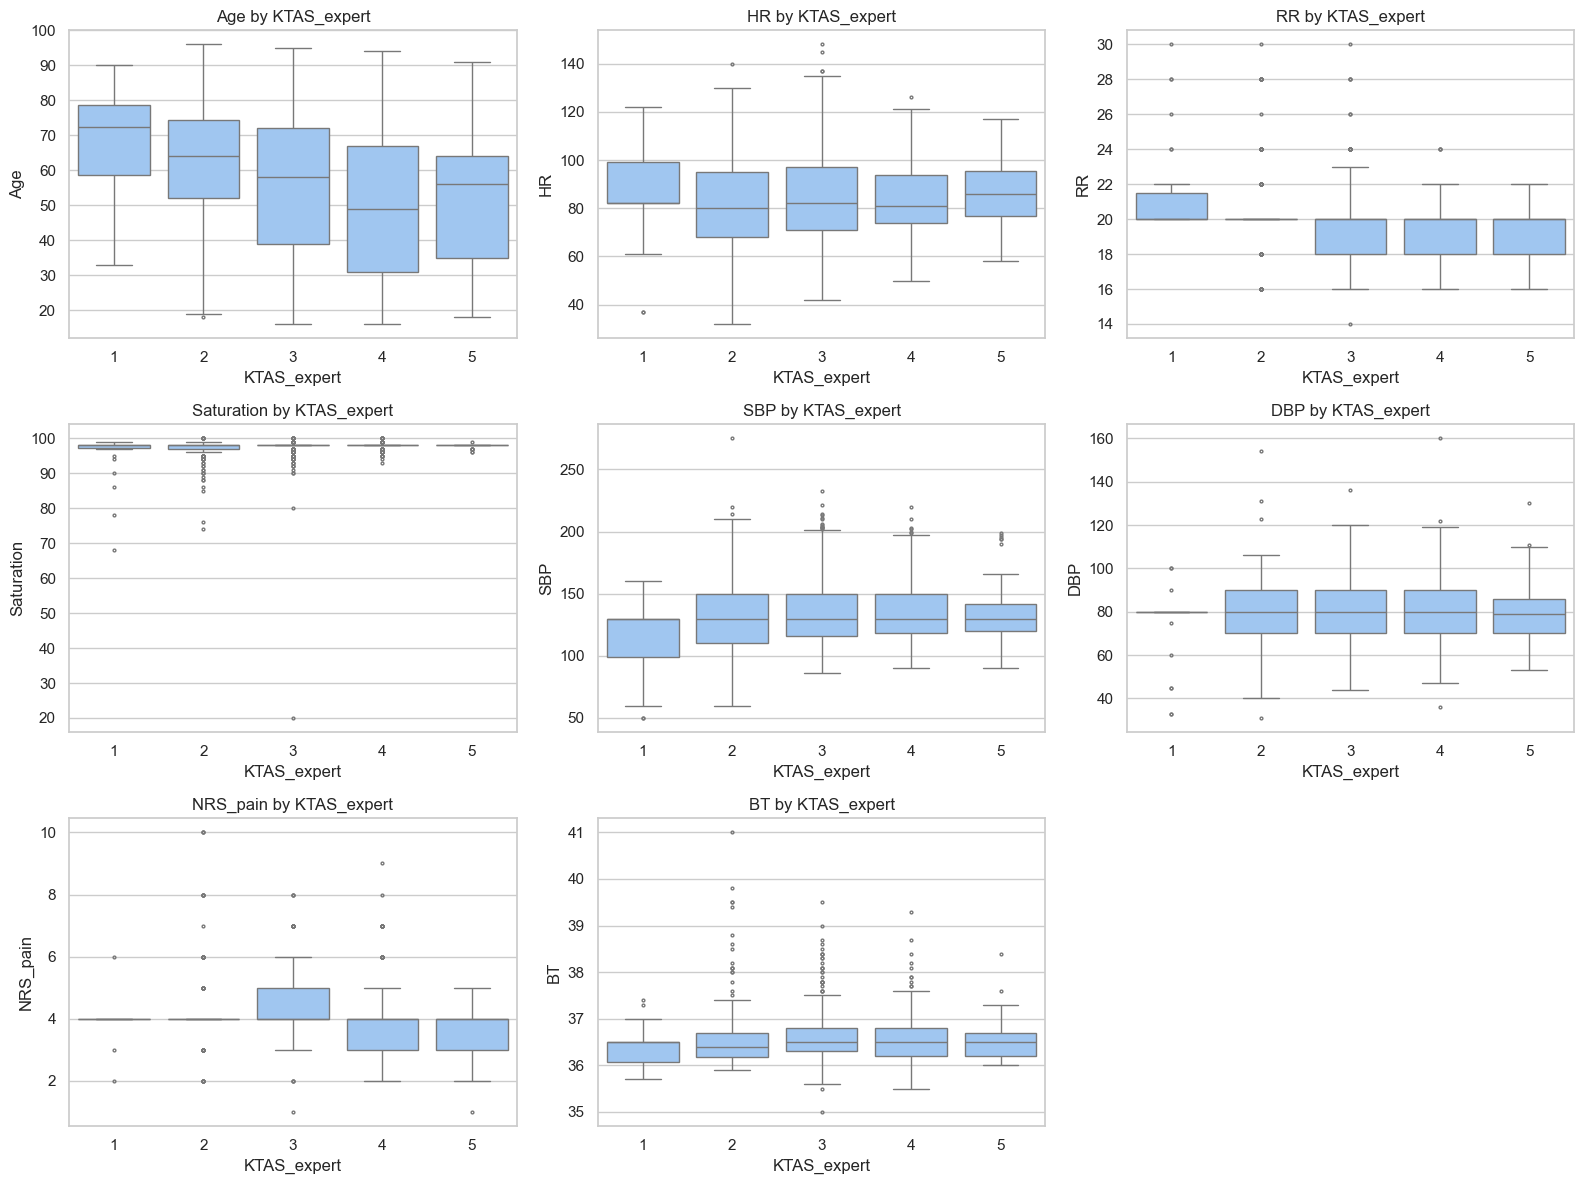

In [8]:
if target_col in df.columns:
    class_order = sorted(df[target_col].dropna().unique())
    vitals_cols = ["Age", "HR", "RR", "Saturation", "SBP", "DBP", "NRS_pain", "BT"]
    vitals_cols = [c for c in vitals_cols if c in df.columns]

    if vitals_cols:
        n_cols = 3
        n_rows = int(np.ceil(len(vitals_cols) / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
        axes = np.array(axes).reshape(-1)

        for i, col in enumerate(vitals_cols):
            sns.boxplot(data=df, x=target_col, y=col, order=class_order, ax=axes[i], color="#93c5fd", fliersize=2)
            axes[i].set_title(f"{col} by KTAS_expert")
            axes[i].set_xlabel("KTAS_expert")

        for j in range(len(vitals_cols), len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print("No vital-sign columns found for boxplots.")
else:
    print("KTAS_expert missing; skipping vital-sign distributions by class.")

### Findings Notes
- Compare medians and spread across KTAS classes to identify physiologic separation.
- RR and saturation usually show clearer class separation than blood pressure in this dataset.
- Wide overlaps between adjacent classes explain why perfect classification is difficult.

,Injury_Yes,Pain_Yes,Sex_Male
KTAS_expert,,,
1,80.77,15.38,53.85
2,89.55,48.18,39.09
3,91.79,47.23,52.77
4,64.92,74.51,49.24
5,80.00,42.67,30.67


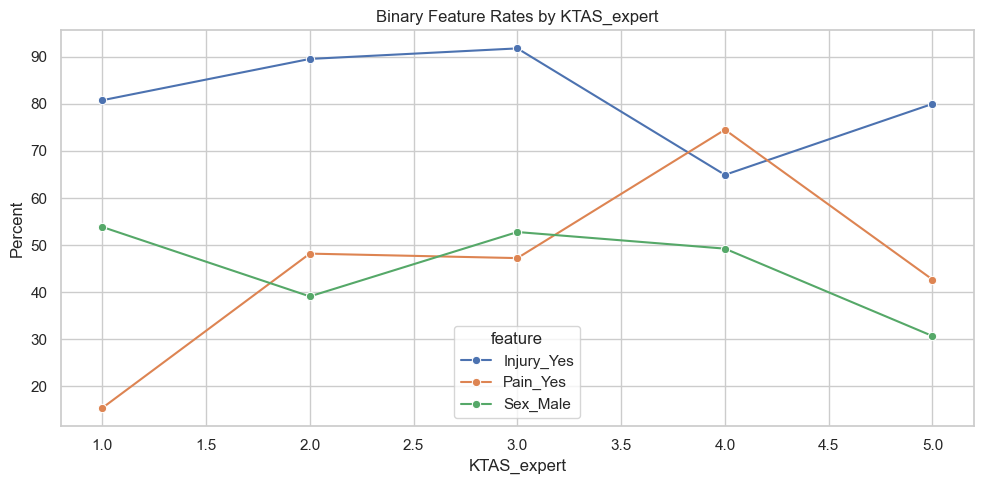

In [9]:
binary_cols = ["Injury_Yes", "Pain_Yes", "Sex_Male"]
available_binary_cols = [c for c in binary_cols if c in df.columns]

if target_col in df.columns and available_binary_cols:
    binary_rates = (df.groupby(target_col)[available_binary_cols].mean() * 100).round(2)
    display(binary_rates)

    plot_df = binary_rates.reset_index().melt(id_vars=target_col, var_name="feature", value_name="percent")
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(data=plot_df, x=target_col, y="percent", hue="feature", marker="o", ax=ax)
    ax.set_title("Binary Feature Rates by KTAS_expert")
    ax.set_ylabel("Percent")
    ax.set_xlabel("KTAS_expert")
    plt.tight_layout()
    plt.show()
else:
    print("KTAS_expert and/or binary columns missing; skipping binary trend analysis.")

### Findings Notes
- Pain-related presentations tend to peak in mid-to-lower acuity groups rather than KTAS 1.
- Injury prevalence varies by class and can help explain class composition shifts.
- Sex proportion differences are present but usually smaller than clinical-vital differences.

## Key Findings (cleaned.csv)

- KTAS classes are imbalanced toward 3-4; KTAS 1 cases are limited.
- Older age, higher RR, lower saturation, and mental-status abnormality track with higher acuity.
- RN labels align closely with expert labels overall, with mostly one-level differences.
- Remaining disagreement pattern shows a meaningful under-triage tendency.